<a href="https://colab.research.google.com/github/LeNovice/Assignments_WILP_SEM3/blob/main/Main_CadenceNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

TODO: Refer

https://debuggercafe.com/getting-95-accuracy-on-the-caltech101-dataset-using-deep-learning/

Data Pipeline:
https://www.tensorflow.org/api_docs/python/tf/data/Dataset#as_numpy_iterator

https://www.tensorflow.org/api_docs/python/tf/data/Dataset#map

Loading the Caltech Dataset

In [15]:
import tensorflow_datasets as tfds
import numpy as np
#For plotting the dataset
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
#Data pipeline preparation
import tensorflow as tf
from tensorflow.keras import layers
#model building
from tensorflow.keras import models

In [16]:
(ds, ds_info) = tfds.load('caltech101', with_info=True)
ds_train = ds["train"]
ds_test = ds["test"]
display(ds_info)

tfds.core.DatasetInfo(
    name='caltech101',
    full_name='caltech101/3.0.1',
    description="""
    Caltech-101 consists of pictures of objects belonging to 101 classes, plus one
    `background clutter` class. Each image is labelled with a single object. Each
    class contains roughly 40 to 800 images, totalling around 9k images. Images are
    of variable sizes, with typical edge lengths of 200-300 pixels. This version
    contains image-level labels only. The original dataset also contains bounding
    boxes.
    """,
    homepage='http://www.vision.caltech.edu/Image_Datasets/Caltech101/',
    data_path='/root/tensorflow_datasets/caltech101/3.0.1',
    file_format=tfrecord,
    download_size=125.64 MiB,
    dataset_size=132.86 MiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'image/file_name': Text(shape=(), dtype=string),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=102),
    }),
    supervised_keys=('image'

tensorflow.python.data.ops.dataset_ops.PrefetchDataset

<tf.Tensor: shape=(), dtype=int64, numpy=70>

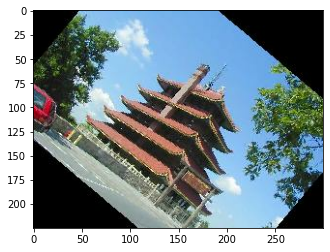

In [17]:
display(type(ds_train))
for example in ds_train:
    image, label = example["image"], example["label"]
    plt.imshow(image)
    display(label)
    break
plt.show()

Data Preprocessing

We could use adapt() methods to get normlazation (feature wise) parameters. https://www.tensorflow.org/guide/keras/preprocessing_layers#the_adapt_method

https://stackoverflow.com/questions/57657386/tensorflow-datasets-reshape-images


MAINLY:
https://www.tensorflow.org/datasets/keras_example

tensorflow.python.data.ops.dataset_ops.ParallelMapDataset

<tf.Tensor: shape=(), dtype=int64, numpy=70>

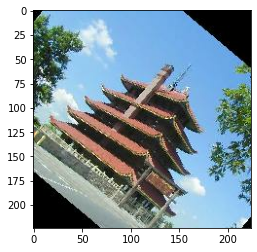

New resized shape for the dataset = (224, 224, 3)


In [19]:
IMG_SIZE = 224
NUM_CHANNELS = 3
BATCH_SIZE=128

def map_func(example):
    resized_image = tf.image.resize_with_crop_or_pad(example["image"], 224, 224)        #TODO: Remove crop as muh as possible
    label = example["label"]
    return {"image":resized_image, "label":label}


resized_ds_train = ds_train.map(map_func, num_parallel_calls=tf.data.AUTOTUNE)


input_shape = ()
display(type(resized_ds_train))
for example in resized_ds_train:
    image, label = example["image"], example["label"]
    plt.imshow(image)
    display(label)
    input_shape = image.shape
    break
plt.show()
print("New resized shape for the dataset = " + str(input_shape))

display few examples

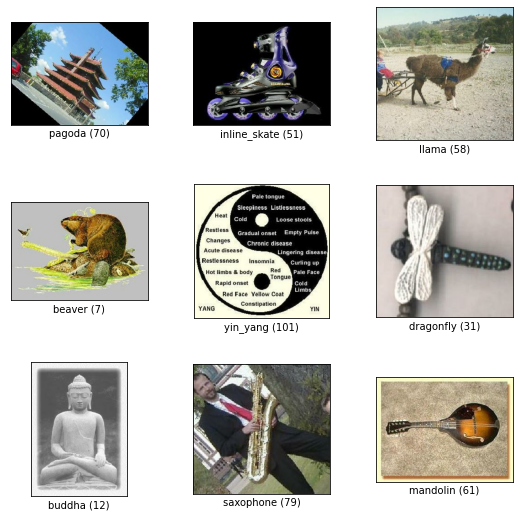

In [20]:
fig = tfds.show_examples(ds_train, ds_info)

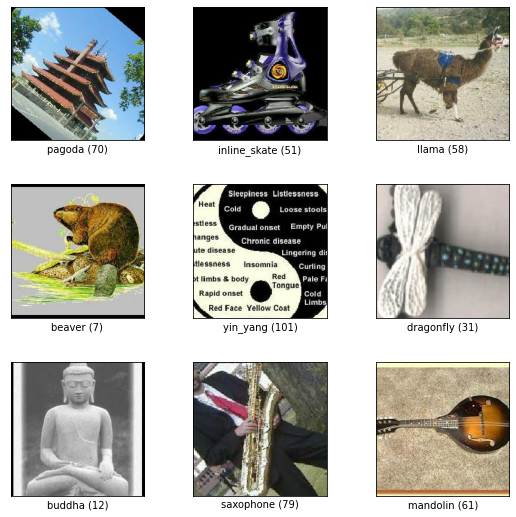

In [21]:
#ds_example = ds_train.take(10)
fig = tfds.show_examples(resized_ds_train, ds_info)

Resizing and re-scaling images to a given dataset.
Tutorial used: https://www.tensorflow.org/tutorials/images/data_augmentation

For data pipeline you may also refer to
https://github.com/tensorflow/datasets/issues/720

Prepare the model
For Batchnorm, refer https://www.tensorflow.org/api_docs/python/tf/keras/layers/BatchNormalization

Here they say that During training, the layer normalizes its output using the mean and standard deviation of the **current batch** of inputs.

In order to make BatchNorm great, should we be using a larger batch as input?

However, during Inference mode, the mean ans tsd deviation does not correspond to the current batch. Rather it is a moving mean and std dev of all the bacthes seen in training phase. (Thus, the parameters in inference phase for batch norm do not change)

In [26]:
model = models.Sequential()
#model.add(resize_and_rescale)

kernel_size = (5,5)
model.add(layers.Conv2D(64, kernel_size, input_shape = input_shape))       #TODO: For instance, after a Conv2D layer with data_format="channels_first", set axis=1 in BatchNormalization.
model.add(layers.BatchNormalization())
pool_size = (2,2)
model.add(layers.MaxPool2D(pool_size))

kernel_size = (3,3)
model.add(layers.Conv2D(192, kernel_size))      #TODO: For instance, after a Conv2D layer with data_format="channels_first", set axis=1 in BatchNormalization.
model.add(layers.BatchNormalization())
pool_size = (2,2)
model.add(layers.MaxPool2D(pool_size))

kernel_size = (3,3)
model.add(layers.Conv2D(64, kernel_size))       #TODO: For instance, after a Conv2D layer with data_format="channels_first", set axis=1 in BatchNormalization.
model.add(layers.BatchNormalization())
pool_size = (2,2)
model.add(layers.MaxPool2D(pool_size))

kernel_size = (3,3)
model.add(layers.Conv2D(128, kernel_size))      #TODO: For instance, after a Conv2D layer with data_format="channels_first", set axis=1 in BatchNormalization.
model.add(layers.BatchNormalization())
pool_size = (2,2)
model.add(layers.MaxPool2D(pool_size))

model.add(layers.Flatten())
model.add(layers.Dense(10, activation='softmax'))

In [27]:
Learning_Rate = 1e-1                                            #https://machinelearningmastery.com/understand-the-dynamics-of-learning-rate-on-deep-learning-neural-networks/
opt = tf.keras.optimizers.Adam(learning_rate=Learning_Rate)     #OR tf.keras.optimizers.SGD(learning_rate=Learning_Rate, momentum=0.0)
model.compile( optimizer = opt, loss = 'categorical_crossentropy', metrics=['accuracy'] )

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 220, 220, 64)      4864      
                                                                 
 batch_normalization_8 (Batc  (None, 220, 220, 64)     256       
 hNormalization)                                                 
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 110, 110, 64)     0         
 2D)                                                             
                                                                 
 flatten_2 (Flatten)         (None, 774400)            0         
                                                                 
 dense_2 (Dense)             (None, 10)                7744010   
                                                                 
Total params: 7,749,130
Trainable params: 7,749,002
No

Reference: https://github.com/tensorflow/datasets/issues/720

In [29]:
resized_ds_train = resized_ds_train.cache()
buffer_size = ds_info.splits['train'].num_examples
resized_ds_train = resized_ds_train.shuffle(buffer_size)
resized_ds_train = resized_ds_train.batch(BATCH_SIZE)
resized_ds_train = resized_ds_train.prefetch(tf.data.AUTOTUNE)

h = model.fit( resized_ds_train, epochs=25)

Epoch 1/25


ValueError: ignored